# Description

A simple model to predict a stock's price given its recent price history.


# Versions
## v2
- Using pytorch-lightning to manage the training loop

## v1
- Context window: 8 days price history
- Linear model predicts next day price
- L2 loss
- Naive strategy of holding stock iff predicted price for day went up
- Table comparing return vs baselines: always hold, and mean price predictor

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

import pandas as pd
import torch as th
import numpy as np

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

# Dataset

In [3]:
from dataclasses import dataclass

batch_size = 128
hist_win = 8
pred_win = 1

@dataclass
class DateRange:
  """Specifies a range of dates, using [start, end)."""
  start: str = None
  end: str = None

train_date_range = DateRange('2003-01-01', '2015-01-01')
eval_date_range = DateRange('2015-01-01', '2020-01-01')

In [4]:
def load_df(ticker, date_range: DateRange):
  """Loads the DataFrame for ticker between [start_date, end_date)."""
  df = pd.read_csv(f'~/data/stock/kaggle/full_history/{ticker}.csv')
  df['date'] = pd.to_datetime(df['date'])
  if date_range.start:
    df = df.query(f'date >= "{date_range.start}"')
  if date_range.end:
    df = df.query(f'date < "{date_range.end}"')
  # reverse so oldest is first
  df = df.iloc[::-1].reset_index(drop=True)
  return df

df_train = load_df('GOOG', train_date_range)
df_valid = load_df('GOOG', eval_date_range)
df_train.head(10)

,date,volume,open,high,low,close,adjclose
0,2004-08-19,44871300,49.813286,51.835709,47.800831,49.982655,49.982655
1,2004-08-20,22942800,50.316402,54.336334,50.062355,53.952770,53.952770
2,2004-08-23,18342800,55.168217,56.528118,54.321388,54.495735,54.495735
3,2004-08-24,15319700,55.412300,55.591629,51.591621,52.239193,52.239193
4,2004-08-25,9232100,52.284027,53.798351,51.746044,52.802086,52.802086
5,2004-08-26,7128600,52.279045,53.773445,52.134586,53.753517,53.753517
6,2004-08-27,6241200,53.848164,54.107193,52.647663,52.876804,52.876804
7,2004-08-30,5221400,52.443428,52.548038,50.814533,50.814533,50.814533
8,2004-08-31,4941200,50.958992,51.661362,50.889256,50.993862,50.993862
9,2004-09-01,9181600,51.158245,51.292744,49.648903,49.937820,49.937820


In [5]:
df_train.tail(10)

,date,volume,open,high,low,close,adjclose
2601,2014-12-17,2883100,495.639221,505.611847,495.449738,503.507629,503.507629
2602,2014-12-18,2926700,511.545563,512.463013,503.318146,509.700623,509.700623
2603,2014-12-19,3690200,510.109497,516.302490,505.523071,514.936218,514.936218
2604,2014-12-22,2723700,514.666992,525.018555,514.666992,523.432922,523.432922
2605,2014-12-23,2197600,525.557068,533.096375,524.848999,529.137268,529.137268
2606,2014-12-24,705900,529.057495,530.303040,525.577026,527.322266,527.322266
2607,2014-12-26,1040500,527.322266,532.787231,525.866211,532.567810,532.567810
2608,2014-12-29,2278500,530.732849,534.013855,528.559814,528.877991,528.877991
2609,2014-12-30,876200,526.644104,529.695740,525.686707,528.967712,528.967712
2610,2014-12-31,1368200,529.795471,531.141724,524.360352,524.958740,524.958740


In [6]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Caveats
#   - looks at only 1 column
class StockSeqDataset(Dataset):
    def __init__(self, df, column='adjclose', hist_win=hist_win, pred_win=pred_win):
        self.df = df
        self.col = column
        self.hist_win = hist_win
        self.pred_win = pred_win
    
    def __getitem__(self, index):
        assert 0 <= index < len(self)
        x_end = index + self.hist_win
        x = self.df.iloc[index:x_end][self.col]
        y = self.df.iloc[x_end:x_end+self.pred_win][self.col]
        return (th.from_numpy(np.array(x, dtype=np.float32)),
                th.from_numpy(np.array(y, dtype=np.float32)))
    
    def __len__(self):
        return len(self.df) - self.hist_win - self.pred_win + 1

ds_train = StockSeqDataset(df_train)
ds_valid = StockSeqDataset(df_valid)
dl_train = DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True)
dl_valid = DataLoader(dataset=ds_valid, batch_size=batch_size, shuffle=False)

In [7]:
ds_train[0]

(tensor([49.9827, 53.9528, 54.4957, 52.2392, 52.8021, 53.7535, 52.8768, 50.8145]),
 tensor([50.9939]))

In [8]:
x, y = next(iter(dl_train))
x.shape, y.shape

(torch.Size([128, 8]), torch.Size([128, 1]))

# Model

In [19]:
import pytorch_lightning as pl

class PricePredictor(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = th.nn.Sequential(
      th.nn.Linear(hist_win, pred_win),
      #th.nn.ReLU(),
      #th.nn.Linear(100, pred_win),
    )
    self.loss_fn = th.nn.MSELoss()

  def forward(self, x):
    return self.model.forward(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    y_pred = self.model(x)
    loss = self.loss_fn(y_pred, y)
    result = pl.TrainResult(loss)
    result.log('train_loss', loss, on_epoch=True)
    return result

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_pred = self.model(x)
    loss = self.loss_fn(y_pred, y)
    result = pl.EvalResult(checkpoint_on=loss)
    result.log('val_loss', loss)
    return result

  def configure_optimizers(self):
    optimizer = th.optim.Adam(self.parameters(), lr=learning_rate,
                              betas=(0.5, 0.5))
    scheduler = th.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
    return [optimizer], [scheduler]

In [20]:
learning_rate = 0.001
max_epochs = 20

predictor = PricePredictor()
model = predictor.model
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(predictor, dl_train, dl_valid)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | model   | Sequential | 9     
1 | loss_fn | MSELoss    | 0     


Epoch 14:  68%|██████▊   | 21/31 [00:00<00:00, 39.86it/s, loss=108.638, v_num=11]
Validating: 0it [00:00, ?it/s]
Epoch 15:  68%|██████▊   | 21/31 [00:00<00:00, 39.88it/s, loss=106.205, v_num=11]
Validating: 0it [00:00, ?it/s]
Epoch 16:  68%|██████▊   | 21/31 [00:00<00:00, 36.05it/s, loss=104.271, v_num=11]
Validating: 0it [00:00, ?it/s]
Epoch 17:  68%|██████▊   | 21/31 [00:00<00:00, 36.65it/s, loss=103.173, v_num=11]
Validating: 0it [00:00, ?it/s]
Epoch 18:  68%|██████▊   | 21/31 [00:00<00:00, 31.72it/s, loss=110.280, v_num=11]
Validating: 0it [00:00, ?it/s]
Epoch 19:  68%|██████▊   | 21/31 [00:00<00:00, 29.46it/s, loss=104.287, v_num=11]
Validating: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████| 31/31 [00:00<00:00, 31.11it/s, loss=104.287, v_num=11]
                                                          

Saving latest checkpoint..


Epoch 19: 100%|██████████| 31/31 [00:01<00:00, 30.92it/s, loss=104.287, v_num=11]


1

# Baseline Models

In [21]:
class MeanModel(th.nn.Module):
    def forward(self, x):
        return x.mean(dim=-1).unsqueeze(axis=1)

# Validation

In [22]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0519,  0.3079,  0.1112,  0.1560,  0.1059,  0.2171, -0.0576,  0.1111]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0597], requires_grad=True)]

In [23]:
def validate(model, ticker):
  assert pred_win == 1
  df = load_df(ticker, eval_date_range)
  ds = StockSeqDataset(df)
  dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False)
  for i, (x, y) in enumerate(dl):
    start = batch_size * i + hist_win  # prediction is offset by hist_win
    end = start + batch_size - 1  # slice end is inclusive
    with th.no_grad():
      y_pred = model(x)
    y = y.cpu().numpy().squeeze()
    y_pred = y_pred.cpu().numpy().squeeze()
    #import pdb; pdb.set_trace()
    df.loc[start:end, 'actual'] = y
    df.loc[start:end, 'pred'] = y_pred
  return df

def plot(df, cols=['actual', 'pred']):
 df.plot(x='date', y=cols, figsize=(10, 8))

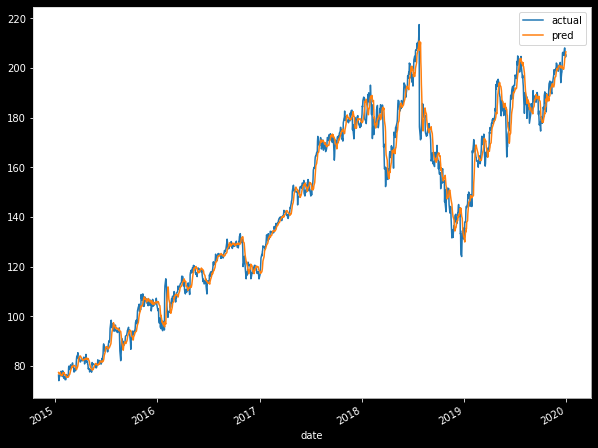

In [24]:
df_pred = validate(model, 'FB')
plot(df_pred)

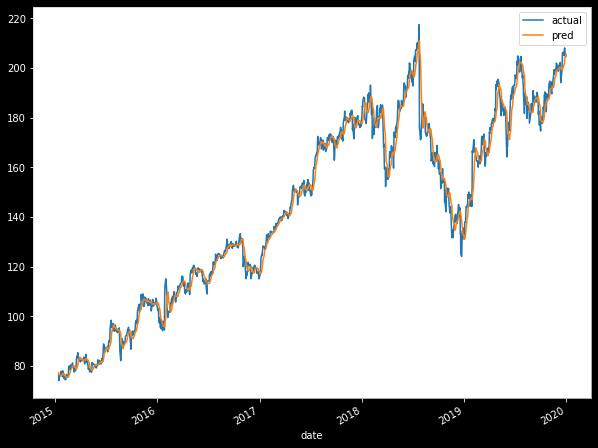

In [25]:
df_pred = validate(MeanModel(), 'FB')
plot(df_pred)

# Strategy

In [26]:
class SimpleStrategy:
  """Simple strategy

  If day's predicted change is positive, hold through day.
  If day's predicted change is negative, skip the day.
  """
  def __init__(self, model):
    self.model = model

  def compute_hold(self, ticker):
    df_pred = validate(self.model, ticker)
    df_pred = df_pred.dropna(subset=('actual', 'pred'))
    actual, pred = df_pred['actual'].values, df_pred['pred'].values
    assert len(actual) == len(pred)
    hold = pred[1:] > pred[:-1]
    return pd.DataFrame.from_dict({
        'actual': actual[1:],
        'pred': pred[1:],
        'hold': hold,
    })

def compute_returns(df):
  df = df.copy()
  df.loc[:, 'roi_actual'] = df.actual / df.actual.shift(1)
  df.loc[:, 'roi_pred'] = df.pred / df.pred.shift(1)
  return df

def total_return(df, query=None):
  if query:
    df = df.query(query)
  roi_actual = df.roi_actual.product()
  roi_pred = df.roi_pred.product()
  return roi_actual, roi_pred

def evaluate_models(models, tickers):
  strats = {name: SimpleStrategy(model) for name, model in models.items()}
  df_actual = pd.DataFrame()
  df_pred = pd.DataFrame()
  
  for ticker in tickers:
    for strat_name, strat in strats.items():
      df_hold = strat.compute_hold(ticker)
      df_roi = compute_returns(df_hold)
      
      all = total_return(df_roi)
      hold = total_return(df_roi, 'hold == True')
      not_hold = total_return(df_roi, 'hold == False')

      df_actual.loc[strat_name + ': all', ticker] = all[0]
      df_actual.loc[strat_name + ': hold', ticker] = hold[0]
      df_actual.loc[strat_name + ': !hold', ticker] = not_hold[0]
      df_pred.loc[strat_name + ': all', ticker] = all[1]
      df_pred.loc[strat_name + ': hold', ticker] = hold[1]
      df_pred.loc[strat_name + ': !hold', ticker] = not_hold[1]
  return df_actual, df_pred


In [27]:
models = {
    'mean': MeanModel(),
    'linear': model,
}
tickers = [
    'FB',
    'GOOG',
    'AAPL',
    'MSFT',
    'SPY',
]

df_actual, df_pred = evaluate_models(models, tickers)
df_actual

,FB,GOOG,AAPL,MSFT,SPY
mean: all,2.771776,2.671817,2.991909,3.862350,1.784635
mean: hold,1.189203,0.970577,1.898921,1.170471,1.270155
mean: !hold,2.330784,2.752813,1.575583,3.299825,1.405052
linear: all,2.771776,2.671817,2.991909,3.862350,1.784635
linear: hold,1.039551,1.271933,3.532091,1.932966,1.538530
linear: !hold,2.666319,2.100595,0.847065,1.998147,1.159961
